## Working with NeuraLogic Evaluators

The NeuraLogic provides convenient evaluators which deal with the learning loop and let the user focus on the semantics and intricacies of the user's problem/program. It is possible to customize the behavior of evaluators by using the settings instance, for example by specifying optimizer, learning rate, number of epochs, and more. Those settings are either being passed into `get_evaluator`, inherited from the model or the problem, or the default settings are used.

In [16]:
from neuralogic.core import Backend
from neuralogic.core.settings import Settings, Optimizer

from neuralogic.utils.data import XOR_Vectorized
from neuralogic.nn import get_evaluator

# Create settings object with optimizer set to SGD and number of epochs to 200 
settings = Settings(optimizer=Optimizer.SGD, epochs=100)

# Get evaluator with the Dynet backend for xor problem
evaluator = get_evaluator(Backend.DYNET, model_and_dataset=XOR_Vectorized(Backend.DYNET, settings))

# To use get_evaluator for problem, pass it as problem argument. Evaluator will build it using the correct backend
# evaluator = get_evaluator(Backend.DYNET, problem=problem)

The training, as well as testing, comes in two forms - generator and non-generator. In which mode the evaluator will run training or testing can be specified using the `generator` argument.

The training in the generator mode yields information about the total loss and the number of samples after each epoch. This allows working with those metrics online, such as plotting them as in the following example.

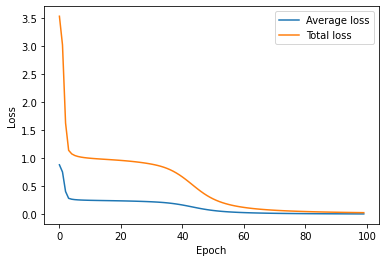

In [17]:
%matplotlib inline 

from IPython.display import clear_output
import matplotlib.pyplot as plt


average_losses = []
total_losses = []

# Get new evaluator
evaluator = get_evaluator(Backend.DYNET, model_and_dataset=XOR_Vectorized(Backend.DYNET, settings))

# Iterate over the training generator and plot loss online
for epoch, (current_total_loss, number_of_samples) in enumerate(evaluator.train(generator=True)):
    clear_output(wait=True)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    average_loss = current_total_loss / number_of_samples
    
    average_losses.append(average_loss)
    total_losses.append(current_total_loss)
    
    plt.plot(average_losses, label="Average loss")
    plt.plot(total_losses, label="Total loss")
    plt.legend()
    plt.pause(0.01)
    plt.show()
    

Setting the `generator` argument to `False` will make the method return only metrics of the last epoch.

In [22]:
# Get new evaluator
evaluator = get_evaluator(Backend.DYNET, model_and_dataset=XOR_Vectorized(Backend.DYNET, settings))

# When the genrerator is set to False, only metrics of the last epochs are returned
total_loss, number_of_samples = evaluator.train(generator=False)

print(total_loss, number_of_samples)

0.0715928953140974 4


The testing in generator mode yields the target and the output of each sample.

In [27]:
from sklearn.metrics import mean_squared_error

for target, output in evaluator.test(generator=True):
    print(f"Target: {target}, Output: {output}, Mean squared error: {mean_squared_error([target], [output])}")

Target: 0.0, Output: 0.0, Mean squared error: 0.0
Target: 1.0, Output: 0.821661651134491, Mean squared error: 0.03180456667607601
Target: 1.0, Output: 0.8146876692771912, Mean squared error: 0.03434065991791968
Target: 0.0, Output: -0.025180313736200333, Mean squared error: 0.0006340481998534792


The testing that is not in the generator mode returns the list of tuples with targets and outputs of all samples.

In [26]:
outputs = evaluator.test(generator=False)
print(outputs)

[(0.0, 0.0), (1.0, 0.821661651134491), (1.0, 0.8146876692771912), (0.0, -0.025180313736200333)]


Outputs in this form can be convenient for additional analysis and metrics gathering.

In [31]:
from sklearn.metrics import max_error, explained_variance_score

np_outputs = np.array(outputs)

print("Max error", max_error(np_outputs[:, 0], np_outputs[:, 1]))
print("Explained variance score", explained_variance_score(np_outputs[:, 0], np_outputs[:, 1]))

Max error 0.18531233072280884
Explained variance score 0.9710181105485837
